In [103]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

In [104]:
data=pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

In [105]:
index_temp=data[data['temp']==0].index
for i in index_temp:
    data['temp'][index_temp]=data['temp'][index_temp-1]
data[data['temp']==0].index

C:\Users\Mastereal\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Int64Index([], dtype='int64')

C:\Users\Mastereal\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


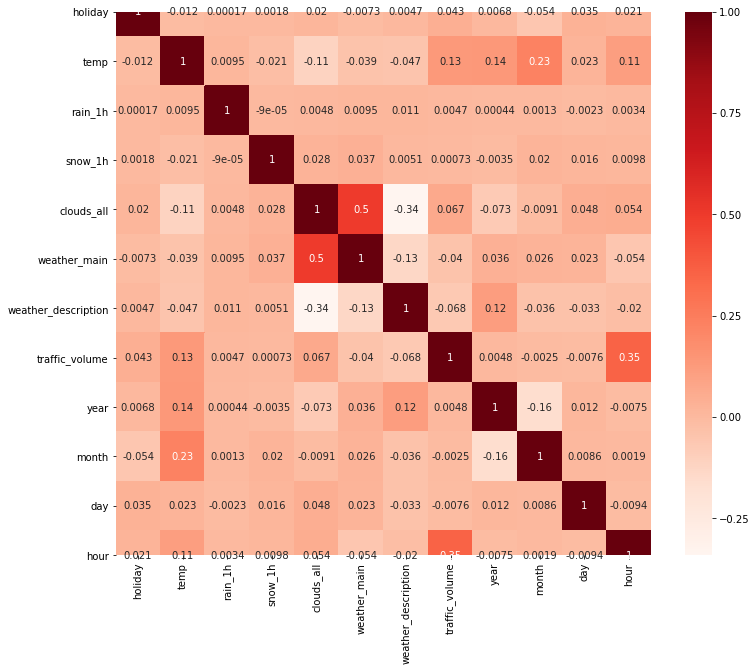

In [106]:
#categorical encoding
holiday_index=data[data['holiday']!='None'].sort_values('date_time').index
holiday_value=data[data['holiday']!='None'].sort_values('date_time')['holiday'].values

for i,name in zip(holiday_index,holiday_value):
    data['holiday'][i:i+24]=name

data['holiday'] = pd.Categorical(data['holiday']).codes
data['weather_main'] = pd.Categorical(data['weather_main']).codes
data['weather_description'] = pd.Categorical(data['weather_description']).codes
data['year'] = data['date_time'].map(lambda x: int(x.split(" ")[0].split("-")[0]))
data['month'] = data['date_time'].map(lambda x: int(x.split(" ")[0].split("-")[1]))
data['day'] = data['date_time'].map(lambda x: int(x.split(" ")[0].split("-")[2]))
data['hour'] = data['date_time'].map(lambda x: int(x.split(" ")[1].split(":")[0]))
data.drop(['date_time'], axis=1, inplace=True)

y = data['traffic_volume'].copy(deep=True)
X = data.copy(deep=True)
X.drop(['traffic_volume'], inplace=True, axis=1)
X.head()

plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Melihat Korelasi features dengan Output

In [107]:
#Correlation with output variable
cor_target = abs(cor["traffic_volume"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target<0.02]
relevant_features

rain_1h    0.004714
snow_1h    0.000733
year       0.004753
month      0.002533
day        0.007587
Name: traffic_volume, dtype: float64

### Wow ternyata features diatas tidak berpengaruh banyak, jadi dihapus aja ya

In [108]:
X.drop(['rain_1h','snow_1h','year','month','day'], inplace=True, axis=1)
X

,holiday,temp,clouds_all,weather_main,weather_description,hour
0,7,288.28,40,1,24,9
1,7,289.36,75,1,2,10
2,7,289.58,90,1,19,11
3,7,290.13,90,1,19,12
4,7,291.14,75,1,2,13
5,7,291.72,1,0,27,14
6,7,293.17,1,0,27,15
7,7,293.86,1,0,27,16
8,7,294.14,20,1,4,17
9,7,293.10,20,1,4,18


### Scaling data, udah nyoba beberapa cara scaling, ini yang paling bagus menurut percobaan

In [109]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler().fit(X) 
X_1 = scaler.transform(X)

### Buat features extraction, gadipake soalnya udah pake features selection dan hasilnya lebih bagus kalo gapake ini

In [110]:
pca=PCA(n_components=4)
X_r=pca.fit(X).transform(X_1)

lda=LinearDiscriminantAnalysis(n_components=4)
X_r2=lda.fit(X,y).transform(X_1)

fa=FactorAnalysis(n_components=4)
X_r3=fa.fit_transform(X_1)

### Percobaan pertama
##### Model : Regresi Linear
##### Train-Test : 60-40
##### Features Selection

[INFO] using linear model
1628.0142668684878
3391130.53117235
0.14587725925157013
1841.5022484841961


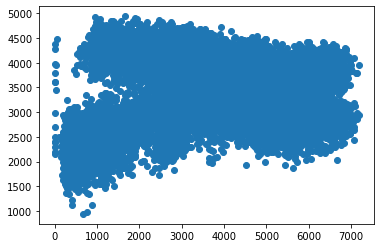

In [111]:
#Original
x_train, x_test, y_train, y_test = train_test_split(X_1,y,test_size=0.4,shuffle=True,random_state=42)
from math import sqrt
print("[INFO] using linear model")
model=LinearRegression()
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error 
print(mean_squared_error(y_test,y_pred)) 

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

print(sqrt(mean_squared_error(y_test,y_pred)))

### Percobaan kedua
##### Model : SVR
##### Train-Test : 60-40
##### Features Selection

[INFO] using linear model
1469.4531428531936
2860893.0086652343
0.2794279798175717
1691.4174554690023


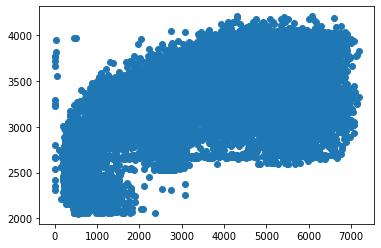

In [112]:
#Original
x_train, x_test, y_train, y_test = train_test_split(X_1,y,test_size=0.4,shuffle=True,random_state=42)
from math import sqrt
print("[INFO] using linear model")
model=SVR(kernel="rbf",gamma="auto")
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error 
print(mean_squared_error(y_test,y_pred)) 

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

print(sqrt(mean_squared_error(y_test,y_pred)))

### Percobaan ketiga
##### Model : SVR 
##### pake 5 Fold Cross Validation
##### Features Selection

Train Index:  [ 9641  9642  9643 ... 48201 48202 48203] 

Test Index:  [   0    1    2 ... 9638 9639 9640]


C:\Users\Mastereal\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 48201 48202 48203] 

Test Index:  [ 9641  9642  9643 ... 19279 19280 19281]


C:\Users\Mastereal\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 48201 48202 48203] 

Test Index:  [19282 19283 19284 ... 28920 28921 28922]


C:\Users\Mastereal\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 48201 48202 48203] 

Test Index:  [28923 28924 28925 ... 38561 38562 38563]


C:\Users\Mastereal\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 38561 38562 38563] 

Test Index:  [38564 38565 38566 ... 48201 48202 48203]


C:\Users\Mastereal\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.31792718204051595, 0.3352005570557891, 0.33500152940493866, 0.33967053522437474, 0.33513388265602784]
1378.4361945851474
2574422.681887193
0.33513388265602784
1604.5007578331627


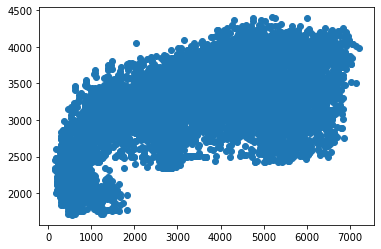

In [115]:
from math import sqrt
from sklearn.model_selection import KFold
scores = []
model = SVR(kernel='rbf')
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X_1[train_index], X_1[test_index], y[train_index], y[test_index]
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

print(scores)
y_pred=model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error 
print(mean_squared_error(y_test,y_pred)) 

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

print(sqrt(mean_squared_error(y_test,y_pred)))

### Percobaan Keempat
##### Model : RandomForest
##### Train-Test : 60-40
##### Features Selection

[INFO] using linear model
606.3888931054516
830265.461034113
0.7908813581168593
911.1890369369646


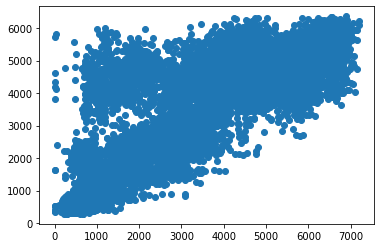

In [116]:
from sklearn.ensemble import RandomForestRegressor
x_train, x_test, y_train, y_test = train_test_split(X_1,y,test_size=0.4,shuffle=True,random_state=42)
from math import sqrt
print("[INFO] using linear model")
model=RandomForestRegressor(bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=9, min_samples_split=19, n_estimators=100)
model.fit(x_train,y_train)

y_pred=model.predict(x_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error 
print(mean_squared_error(y_test,y_pred)) 

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

print(sqrt(mean_squared_error(y_test,y_pred)))

### Percobaan Terakhir (Dah capek Mbak)
##### Model : RandomForest
##### Pake 5 Fold Cross Validation
##### Features Selection

Train Index:  [ 9641  9642  9643 ... 48201 48202 48203] 

Test Index:  [   0    1    2 ... 9638 9639 9640]
Train Index:  [    0     1     2 ... 48201 48202 48203] 

Test Index:  [ 9641  9642  9643 ... 19279 19280 19281]
Train Index:  [    0     1     2 ... 48201 48202 48203] 

Test Index:  [19282 19283 19284 ... 28920 28921 28922]
Train Index:  [    0     1     2 ... 48201 48202 48203] 

Test Index:  [28923 28924 28925 ... 38561 38562 38563]
Train Index:  [    0     1     2 ... 38561 38562 38563] 

Test Index:  [38564 38565 38566 ... 48201 48202 48203]
[0.7633564283208393, 0.7675164248918448, 0.7566533823760284, 0.7911350578557983, 0.7772569822087265]
617.5062037434894
862481.4263729241
0.7772569822087265
928.6987812918267


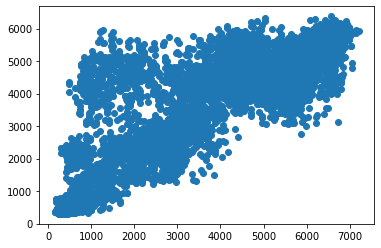

In [117]:
from math import sqrt
from sklearn.model_selection import KFold
scores = []
model = RandomForestRegressor(bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=9, min_samples_split=19, n_estimators=100)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X_1[train_index], X_1[test_index], y[train_index], y[test_index]
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

print(scores)
y_pred=model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error 
print(mean_squared_error(y_test,y_pred)) 

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

print(sqrt(mean_squared_error(y_test,y_pred)))

## Yang paling bagus percobaan 4 dengan r2=79%
# --------------------------------- Sekian dan Terima Kasih -------------------------------